In [1]:
%matplotlib inline
from IPython.display import display
from matplotlib import pyplot as plt

import os
import sys
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
from datetime import datetime

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

sys.path.append('../')
from MyPyUtil.logconf import logging
from MyPyUtil.util import show_more_rows, seed_everything

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

seed_everything()

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = "{:.3f}".format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g

data_dir = f"{os.getcwd()}/../data/"
resources_dir = f"{os.getcwd()}/../resources/"

if os.path.exists(resources_dir) == False:
    os.makedirs(resources_dir, exist_ok=True)

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir, exist_ok=True)

## Load Stock Data


In [3]:
import joblib
from build_stocks_data import tick_data_info

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
empty_vol_threshold = 10

stks_data_file = (
    f"{resources_dir}nasdaq_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.pkl"
)

if os.path.exists(stks_data_file):
    stks_data = joblib.load(stks_data_file)
else:
    from build_stocks_data import build_stocks_data

    log.setLevel(logging.ERROR)
    stks_data = build_stocks_data(
        start, end, empty_vol_threshold, data_dir, resources_dir
    )
    joblib.dump(stks_data, stks_data_file)
    log.setLevel(logging.INFO)

display(f"The data has been loaded for a total of {len(stks_data)} stocks.")

'The data has been loaded for a total of 2260 stocks.'

In [4]:
stks_data[0].tick_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-16,69.750,72.750,64.200,67.500,67.500,1527
2018-02-20,65.700,66.000,63.750,66.000,66.000,353
2018-02-21,60.000,74.850,60.000,71.250,71.250,733
2018-02-22,67.650,71.250,66.750,68.745,68.745,213
2018-02-23,65.250,67.500,65.250,67.500,67.500,360
...,...,...,...,...,...,...
2023-12-22,1.980,2.060,1.900,1.970,1.970,725600
2023-12-26,2.030,2.095,1.990,2.010,2.010,477200
2023-12-27,2.010,2.100,2.010,2.080,2.080,608300


In [5]:
short_ind = 5
long_ind = 10


def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    # adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    # adjusted_OHLV = adjusted_OHLV.dropna()
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    # adjusted_OHLV["B4_Adj Open pct"] = (
    #     adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj High pct"] = (
    #     adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Low pct"] = (
    #     adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Volume pct"] = (
    #     adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    # ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV

&#128293; &#9778;
reference:

1. ![candlestick_patterns_8_trigrams](candlestick_patterns_8_trigrams.png)
2. [From Technical Indicators to Machine Learning: A Data-Driven Approach to Price Movement Forecasting](https://medium.com/@nemeth.marcell/from-technical-analysis-to-machine-learning-a-data-driven-approach-to-stock-price-forecasting-pt-1-66a4e3751b00)
3. [Stock Trend Prediction Using Candlestick Charting and Ensemble Machine Learning Techniques With a Novelty Feature Engineering Scheme](Stock_Trend_Prediction_Using_Candlestick_Charting_.pdf)


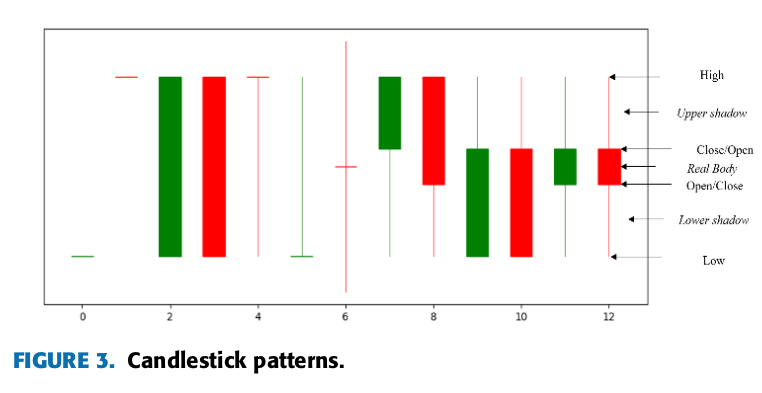
**classes:**  
0.

1.
2. CDLMARUBOZU - -100
3. CDLMARUBOZU - 100
4. CDLDOJI, 100, 收盤價 = 最高價
5. CDLDOJI, -100, 收盤價 = 最低價
6. CDLDOJI, 100, except 4 and 5
7. CDLHAMMER, -100 開盤價 = 最高價
8. CDLHAMMER, 100 收盤價 = 最高價
9. CDLINVERTEDHAMMER, -100 收盤價 = 最低價
10. CDLINVERTEDHAMMER, 100 開盤價 = 最低價
11. CDLSHORTLINE, CDLLONGLINE, -100
12. CDLSHORTLINE, CDLLONGLINE, 100


In [6]:
import pandas_ta

# Category
# with show_more_rows():
display(pandas_ta.Category)
help(pandas_ta.macd)

{'candles': ['cdl_pattern', 'cdl_z', 'ha'],
 'cycles': ['ebsw'],
 'momentum': ['ao',
  'apo',
  'bias',
  'bop',
  'brar',
  'cci',
  'cfo',
  'cg',
  'cmo',
  'coppock',
  'cti',
  'er',
  'eri',
  'fisher',
  'inertia',
  'kdj',
  'kst',
  'macd',
  'mom',
  'pgo',
  'ppo',
  'psl',
  'pvo',
  'qqe',
  'roc',
  'rsi',
  'rsx',
  'rvgi',
  'slope',
  'smi',
  'squeeze',
  'squeeze_pro',
  'stc',
  'stoch',
  'stochrsi',
  'td_seq',
  'trix',
  'tsi',
  'uo',
  'willr'],
 'overlap': ['alma',
  'dema',
  'ema',
  'fwma',
  'hilo',
  'hl2',
  'hlc3',
  'hma',
  'ichimoku',
  'jma',
  'kama',
  'linreg',
  'mcgd',
  'midpoint',
  'midprice',
  'ohlc4',
  'pwma',
  'rma',
  'sinwma',
  'sma',
  'ssf',
  'supertrend',
  'swma',
  't3',
  'tema',
  'trima',
  'vidya',
  'vwap',
  'vwma',
  'wcp',
  'wma',
  'zlma'],
 'performance': ['log_return', 'percent_return'],
 'statistics': ['entropy',
  'kurtosis',
  'mad',
  'median',
  'quantile',
  'skew',
  'stdev',
  'tos_stdevall',
  'variance',

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

In [7]:
if "candle_signal" in sys.modules:
    print("delete candle_signal module")
    del sys.modules["candle_signal"]
from candle_signal import create_candle_signals

if "eight_trigrams" in sys.modules:
    print("delete eight_trigrams module")
    del sys.modules["eight_trigrams"]
from eight_trigrams import create_trigrams

if "awesome_oscillator" in sys.modules:
    print("delete awesome_oscillator module")
    del sys.modules["awesome_oscillator"]
from awesome_oscillator import detect_awesome_saucers

if "macd_strategy" in sys.modules:
    print("delete macd_strategy")
    del sys.modules["macd_strategy"]
import macd_strategy

if "cti_strategy" in sys.modules:
    print("delete cti_strategy")
    del sys.modules["cti_strategy"]
import cti_strategy

if "er_strategy" in sys.modules:
    print("delete er_strategy")
    del sys.modules["er_strategy"]
import er_strategy

if "eri_strategy" in sys.modules:
    print("delete eri_strategy")
    del sys.modules["eri_strategy"]
import eri_strategy

import pandas_ta as ta


stk_data = stks_data[4].tick_data
short_ind = 5
long_ind = 10

adjusted_OHLV = to_adjusted(stk_data)

data = pd.concat(
    [
        eri_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            length=13,
            prefix="c",
            suffix="m",
        ),
        er_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.er(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        cti_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=5,
            slow=10,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=5,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=10,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cfo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stochrsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cmo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stoch(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rvi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="v",
        ),
        adjusted_OHLV.ta.mfi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="f",
            suffix="m",
        ),
        macd_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=12,
            slow=26,
            signal=9,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.brar(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            scalar=1,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bop(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bias(close="Adj Close", prefix="f", suffix="m"),
        detect_awesome_saucers(
            adjusted_OHLV, high="Adj High", low="Adj Low", prefix="c", suffix="m"
        ),
        create_trigrams(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="t",
        ),
        create_candle_signals(
            adjusted_OHLV,
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="c",
        ),
    ],
    axis=1,
)

with show_more_rows():
    display(data.head(100))

data = data.dropna()
display(data)

"""
# OVERLAP INDICATORS
data = pd.DataFrame()
# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
# data["sar"] = tb.SAR(df["High"], df["Low"])

# MOMENTUM INDICATORS
data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)
data["mfi"] = tb.MFI(
    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
)
data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

# # VOLUME INDICATORS
# data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
# data["adosc"] = tb.ADOSC(
#     df["High"],
#     df["Low"],
#     df["Close"],
#     df["Volume"],
#     fastperiod=short_ind,
#     slowperiod=long_ind,
# )
# data["obv"] = tb.OBV(df["Close"], df["Volume"])
data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

# data.reset_index(drop=True, inplace=True)
display(data)
display(create_trigrams(df))
# TARGET
# data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

# data.dropna(inplace=True)

# columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

# if custom == True:
#     df = create_signals(data=df)
#     columns = columns + [
#         "shortLineCdl",
#         "longLineCdl",
#         "spinningTop",
#         "closingMarubozu",
#     ]

# if "O" in additional:
#     columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
# if "M" in additional:
#     columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
# if "V" in additional:
#     columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

# df = df[columns]
"""

[X] Ooops!!! It's True, the series 'high' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume
[X] Ooops!!! It's True, the series 'low' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume


,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-02-25,0.000,0.000,0.000,0.000,0.149,0.000,0.000,-0.920,-0.716,-0.428,41.923,54.023,-12.038,43.981,48.665,57.386,46.323,65.745,0.000,0.000,0.000,0.000,1.214,0.851,-0.854,-0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

'\n# OVERLAP INDICATORS\ndata = pd.DataFrame()\n# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)\n# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)\n# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)\n# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)\n# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)\n# data["sar"] = tb.SAR(df["High"], df["Low"])\n\n# MOMENTUM INDICATORS\ndata["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)\ndata["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])\ndata["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(\n    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9\n)\ndata["mfi"] = tb.MFI(\n    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind\n)\ndata["mom"] = tb.MOM(df["Close"], timeperiod=long